In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns


C:\Users\maksd\AppData\Local\Temp\ipykernel_23400\1036662087.py:5: RuntimeWarning: divide by zero encountered in log2
  plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
C:\Users\maksd\AppData\Local\Temp\ipykernel_23400\1036662087.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")


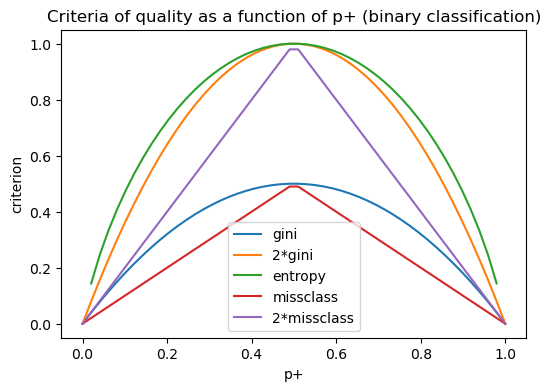

In [10]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label="2*gini")
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label="2*missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Criteria of quality as a function of p+ (binary classification)")
plt.legend();

In [11]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

print(train_data)

[[ 2.76265890e-01 -1.85462808e+00]
 [ 6.23901111e-01  1.14531129e+00]
 [ 1.03719047e+00  1.88663893e+00]
 [-1.11698290e-01 -3.62101338e-01]
 [ 1.48675045e-01 -4.37783153e-01]
 [ 2.17125700e+00  1.15231025e+00]
 [-1.81881234e+00 -1.38049341e-01]
 [ 5.39839614e-01 -1.77528229e+00]
 [ 1.31487654e+00 -4.73448047e-01]
 [-1.09222990e+00 -2.50027442e-01]
 [-9.82294304e-01  1.03126909e+00]
 [ 4.91333776e-01 -4.46646604e-01]
 [-8.06360082e-01  1.31267758e-01]
 [-1.21256024e+00  1.59990853e-01]
 [-7.55223036e-01  3.49895992e-01]
 [ 9.77541764e-01 -1.38585250e-01]
 [ 1.03856305e-01  3.00591036e-01]
 [ 9.68205296e-01  8.69623842e-01]
 [ 5.67783089e-01  4.65282344e-01]
 [-1.16537308e+00 -2.03599479e+00]
 [-1.15541329e+00  3.34515739e+00]
 [ 1.26727211e-01 -6.94178896e-01]
 [ 5.57674431e-01  9.91466000e-02]
 [ 6.37926174e-01  7.03110681e-01]
 [-9.16093154e-01 -7.86014228e-01]
 [ 1.11918180e+00 -9.83396109e-01]
 [ 2.44520021e-01 -5.81409738e-01]
 [ 4.29563902e-01  7.98401988e-01]
 [-6.10070049e-01  1

In [16]:
a = np.random.normal(loc = 4, size = (50))
b = np.random.normal(loc = 2, size = (50))

In [22]:
np.r_[a,b]

AxisError: axis 2 is out of bounds for array of dimension 1

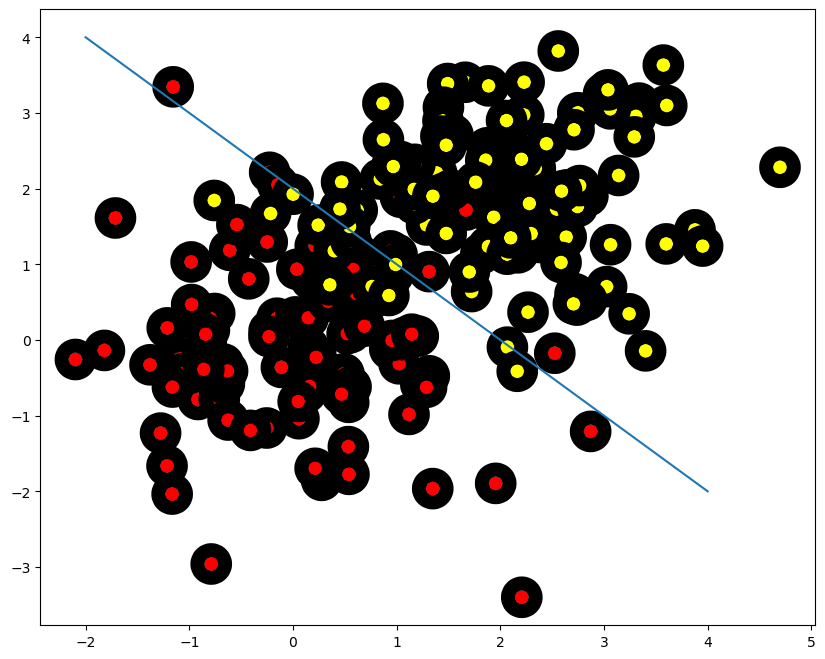

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,#цвет точек
    s=100, #размер точек
    cmap="autumn",
    edgecolors="black",
    linewidth=20,#размер границ
)
plt.plot(range(-2, 5), range(4, -3, -1))

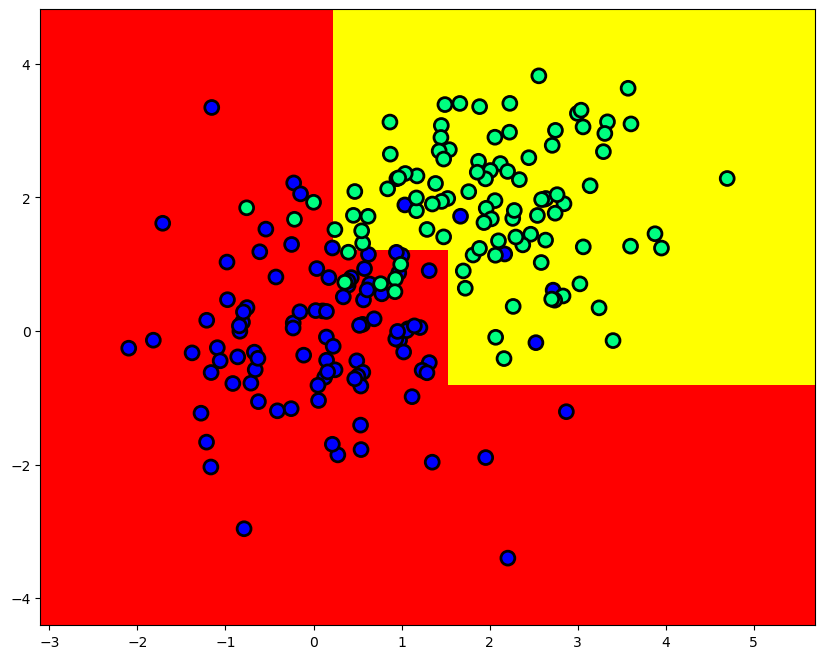

In [57]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 8))
#plt.scatter(xx, yy, marker='o', color='k')
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="winter",
    edgecolors="black",
    linewidth=2,
)

In [52]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [53]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="topic3_decision_tree1.png",
)

In [58]:
data = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [59]:
age_tree = DecisionTreeClassifier(random_state=17, criterion = 'entropy')
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)

tree_graph_to_png(
    age_tree,
    feature_names=["Age"],
    png_file_to_save="topic3_decision_tree2.png",
)

In [60]:
age_tree = DecisionTreeClassifier(random_state=17, criterion = 'gini')
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)

tree_graph_to_png(
    age_tree,
    feature_names=["Age"],
    png_file_to_save="topic3_decision_tree3.png",
)

In [62]:
data.Age.mean()

34.45454545454545

<Axes: ylabel='Age'>

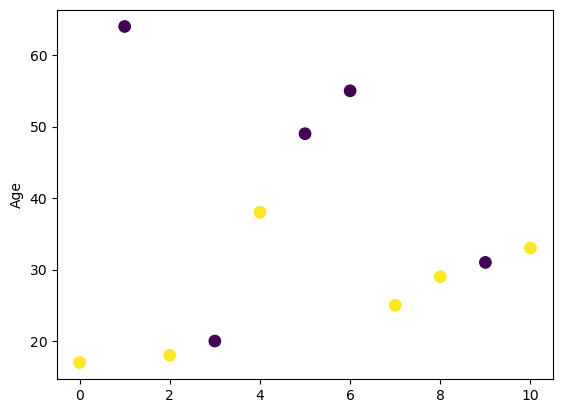

In [65]:
sns.scatterplot(x = data.index, y = data.Age, c = data['Loan Default'], s = 100)